# Covid 19 education challenge
This is a notebook using the data from the covid 19 education challenge. [(Link to kaggle)](https://www.kaggle.com/c/learnplatform-covid19-impact-on-digital-learning)

Within in the notebook we:
- Visualize the engagement index, aggregated over all products for each state of the US.
- 

In [37]:
# !python -m pip install mitoinstaller -qqq
# !python -m mitoinstaller install -qqq

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path

import plotly as py
import plotly.express as px

# from pandas_profiling import ProfileReport
data_dir = Path("./data")



In [27]:
def create_running_average(df: pd.DataFrame, category: str, kernel_size: int=8, out_category_prefix="running_average_"):
    runn_avg_colname = f"{out_category_prefix}{category}"
    df[runn_avg_colname] = 0
    for state in df.state:
        state_mask = df.state == state
        column = df.loc[state_mask, category].values
        running_mean = np.convolve(column, np.ones(kernel_size)/kernel_size, mode="same")
        df.loc[state_mask, runn_avg_colname] = running_mean

<div style="background-color: #f0f0f0; padding: 10px; border: 2px solid #4a4a4a; border-radius: 5px">
<h2 style="color: #3b3b3b">Available data 🗓📌</h2>

<h3 style="color: #3b3b3b">What does the data include?</h3>

- Two measures of learning engagement  (`pct_access` and `engagement_index`) aggregated over **234** US school districts.
- The top **372** ed-tech products (out of **10000**) identified by the Chrome browser extension [learnplatform](https://learnplatform.com/).
- Information about the **234** school districts - heavily anonymized with sideeffects of introduced ranges (instead of actual values) and a lot of missing values.

<h2 style="color: #3b3b3b">Understanding the engagement data 🤓📚</h2>

<h3 style="color: #3b3b3b">Given definitions</h3> 

- `pct_access`: Percentage of students in the district have at least one page-load event of a given product and on a given day

    - **Example**: 15% of students in a district in Utah engaged at least once with  on Monday April 14.
    - **Question**: Some numbers are > 1. What should that mean?

- `engagement_index`: Total page-load events per one thousand students of a given product and on a given day

    - **In simple terms**: Shows how active the students are in the district.
    - **Example**: 341 engagement events per 1000 students were recorded in Chicago on Monday April 14.

<h2 style="color: #3b3b3b">Understanding the product data 🤓📚</h2>

<h3 style="color: #3b3b3b">Sector(s)</h3>

- **Issues**: 
    - What does the sector `PreK-12; Higher Ed; Corporate` exactly cover?
    - `LC - Study Tools` contains Grammarly, `Other` contains `Facebook` -- check relevance for each hypothesis!
</div>

<div style="background-color: #f0f0f0; padding: 10px; border: 2px solid #4a4a4a; border-radius: 5px">
<h2 style="color: #3b3b3b">Exploration Ideas 💡</h2>

1. Did school topics change pre/post Covid? 
    - **Hypothesis**: Pre-covid most online education was math/science. Post-covid other areas got significantly more traction.
2. Does race or economical background of a district play a role in online learning adoption? **(André)**
3. Analysing the primary essential functions of learning products:
    - Are there significant differences in engagement when comparing the categories `Learning & Curriculum (LC)`, `CM = Classroom Management` and `SDO = School & District Operations`?
4. Do `pptotalraw` of a district and online education engagement correlate?
5. Did "real" online learning increase or just usage of "other" tools like e.g. Google Docs / Facebook etc.? **(Robin)**
6. Do increased online engagement rates of online learning platforms correlate with e.g. increase in social media usage?
    - What is the ratio between distractive vs. actual educational tools?
    - More general question: Which role do tools which are commonly known for being distracting (e.g. Facebook) play in online education?
    - **TODO**: Compare page loads of e.g. `Google Docs` and learning platforms.

</div>

# Load Data

### Load & concatenate: Engagement data for all districts

In [4]:
import glob
import pandas as pd 

all_file_names = list(data_dir.glob("engagement_data/*.csv"))
data_of_district = []

for filename in all_file_names:
    df = pd.read_csv(filename, index_col=None, header=0)
    district_id = filename.stem
    df["district_id"] = district_id
    data_of_district.append(df)

engagement = pd.concat(data_of_district)
engagement = engagement.reset_index(drop=True)
engagement.head()

,time,lp_id,pct_access,engagement_index,district_id
0,2020-01-01,29322.0,0.04,1.30,3188
1,2020-01-01,57084.0,0.04,0.43,3188
2,2020-01-01,99916.0,0.09,5.20,3188
3,2020-01-01,58235.0,0.00,NaN,3188
4,2020-01-01,11585.0,0.04,1.30,3188


### Load & Extract: Products data

In [5]:
products = pd.read_csv(data_dir / "products_info.csv")

products['Basic_category'] = 'x'
for i in range(len(products)):
    if pd.isna(products.loc[i, 'Primary Essential Function']) == False:
        products.loc[i, 'Basic_category'] = products.loc[i, 'Primary Essential Function'].split('-')[0][:-1]

products.head()

,LP ID,URL,Product Name,Provider/Company Name,Sector(s),Primary Essential Function,Basic_category
0,13117,https://www.splashmath.com,SplashLearn,StudyPad Inc.,PreK-12,LC - Digital Learning Platforms,LC
1,66933,https://abcmouse.com,ABCmouse.com,"Age of Learning, Inc",PreK-12,LC - Digital Learning Platforms,LC
2,50479,https://www.abcya.com,ABCya!,"ABCya.com, LLC",PreK-12,"LC - Sites, Resources & Reference - Games & Si...",LC
3,92993,http://www.aleks.com/,ALEKS,McGraw-Hill PreK-12,PreK-12; Higher Ed,LC - Digital Learning Platforms,LC
4,73104,https://www.achieve3000.com/,Achieve3000,Achieve3000,PreK-12,LC - Digital Learning Platforms,LC


### Load + drop: Districts data

In [28]:
districts = pd.read_csv(data_dir /"districts_info.csv")
districts.dropna(inplace = True)

# Average anonymized data ranges: [0.18, 1.[ --> 0.59, etc.
for col in ['pct_black/hispanic', 'pct_free/reduced', 'pp_total_raw', 'county_connections_ratio']:
    districts[col] = districts[col].apply(lambda val: mean([float(x) for x in val[1:-1].split(',')]))

districts.head()

,district_id,state,locale,pct_black/hispanic,pct_free/reduced,county_connections_ratio,pp_total_raw
0,8815,Illinois,Suburb,0.1,0.1,0.59,15000.0
2,4921,Utah,Suburb,0.1,0.3,0.59,7000.0
5,5987,Wisconsin,Suburb,0.1,0.1,0.59,11000.0
6,3710,Utah,Suburb,0.1,0.5,0.59,7000.0
7,7177,North Carolina,Suburb,0.3,0.3,0.59,9000.0


In [7]:
from statistics import mean



districts.head()

,district_id,state,locale,pct_black/hispanic,pct_free/reduced,county_connections_ratio,pp_total_raw
0,8815,Illinois,Suburb,0.1,0.1,0.59,15000.0
2,4921,Utah,Suburb,0.1,0.3,0.59,7000.0
5,5987,Wisconsin,Suburb,0.1,0.1,0.59,11000.0
6,3710,Utah,Suburb,0.1,0.5,0.59,7000.0
7,7177,North Carolina,Suburb,0.3,0.3,0.59,9000.0


## Merge products and engagement data - create plot of engagement for every state

In [30]:
merged_data = pd.merge(products, engagement, left_on = 'LP ID', right_on = 'lp_id')

merged_data['district_id'] = merged_data['district_id'].astype('int64')
merged_data = pd.merge(merged_data, districts, on = 'district_id')
merged_data.drop(['URL', 'lp_id'], axis = 1, inplace = True)

# Add time as integer
timeAsInt = [int("".join(x.split("-"))) for x in merged_data['time']]
merged_data['time_as_int'] = timeAsInt

# replace NaNs with 0.0
merged_data.loc[:, ["engagement_index"]] = merged_data["engagement_index"].fillna(0, inplace=False)

# Engagement per State over Time

In [20]:
st_acсess = merged_data.groupby(['state', 'time']).agg({'pct_access': 'mean'}).reset_index()
st_eng = merged_data.groupby(['state', 'time']).agg({'engagement_index': 'mean'}).reset_index()

loc_acсess = merged_data.groupby(['locale', 'time']).agg({'pct_access': 'mean'}).reset_index()
loc_eng = merged_data.groupby(['locale', 'time']).agg({'engagement_index': 'mean'}).reset_index()
cat_acсess = merged_data.groupby(['Basic_category', 'time']).agg({'pct_access': 'mean'}).reset_index()
cat_eng = merged_data.groupby(['Basic_category', 'time']).agg({'engagement_index': 'mean'}).reset_index()

In [62]:
st_acсess.head(3)
create_running_average(st_acсess, 'pct_access')
create_running_average(st_eng, 'engagement_index')

Covid19 - Important dates 2020

- **March 11** — WHO Declares COVID-19 a Pandemic
- Summer Vacation

taken from [this timeline](https://www.ajmc.com/view/a-timeline-of-covid19-developments-in-2020).

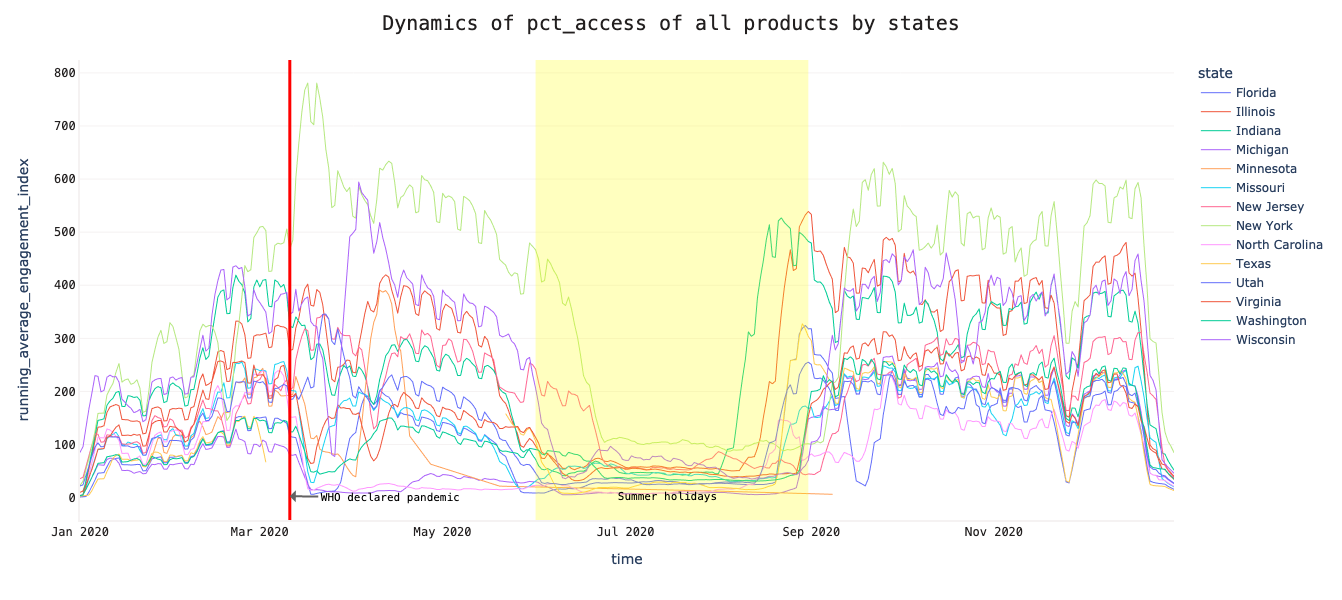

In [63]:
fig = px.line(st_eng, x="time", y="running_average_engagement_index", color="state", line_group="state")

fig.update_layout(plot_bgcolor = 'white', title = 'Dynamics of pct_access of all products by states', 
                  title_font_family = 'monospace', title_font_color = '#221f1f', title_font_size = 20, 
                  title_x = 0.5, width=1300, height=600)
fig.update_xaxes(showline = True, linecolor = '#f5f2f2', linewidth = 2, tickfont_family = 'monospace', 
                 tickfont_color = '#221f1f', tickfont_size = 12)
fig.update_yaxes(showline = True, linecolor = '#f5f2f2', 
                 showgrid = True, gridwidth = 1, gridcolor = '#f5f2f2',
                 linewidth = 2, tickfont_family = 'monospace', tickfont_color = '#221f1f', tickfont_size = 12)

fig.add_vline(x = '2020-03-11', line_width = 3, line_color="red")

fig.add_annotation(
        x='2020-03-11',
        y=2.7,
        text="WHO declared pandemic",
        showarrow=True,
        font=dict(
            family="monospace",
            size=11,
            color="black"
            ),
        arrowhead=1,
        arrowsize=1,
        arrowwidth=2,
        arrowcolor="#636363",
        ax= 100,
        ay=1
        )

fig.add_vrect(x0="2020-06-01", x1="2020-08-31", fillcolor="yellow", opacity=0.25, line_width=0)

fig.add_annotation(
        x='2020-07-15',
        y=2.25,
        text="Summer holidays",
        showarrow=False,
        font=dict(
            family="monospace",
            size=11,
            color="black"
            )
        )

fig.update_traces(line_width=1)

fig.show()

Analysis of the graph above:
- Shortly after the WHO declared covid-19 a pandemic, engagement index changes drastically within each state.
    - While some states show a steep rise (New York, etc.), other states show a steep decline in engagement (North Carolina, etc.)
- In the time around the summer holidays in the U.S., engagement drops very low compared to all other times.
- More drops, similar to that of the summer holidays can be seen during other dates as well.

# Districts analysis

In [13]:
covid_date_who_pandemic = 20200311

# District type pre-covid
total = len(merged_data)
merged_data_pre_covid = merged_data[merged_data['time_as_int'] <= 20200311]
merged_data_post_covid = merged_data[merged_data['time_as_int'] > 20200311]

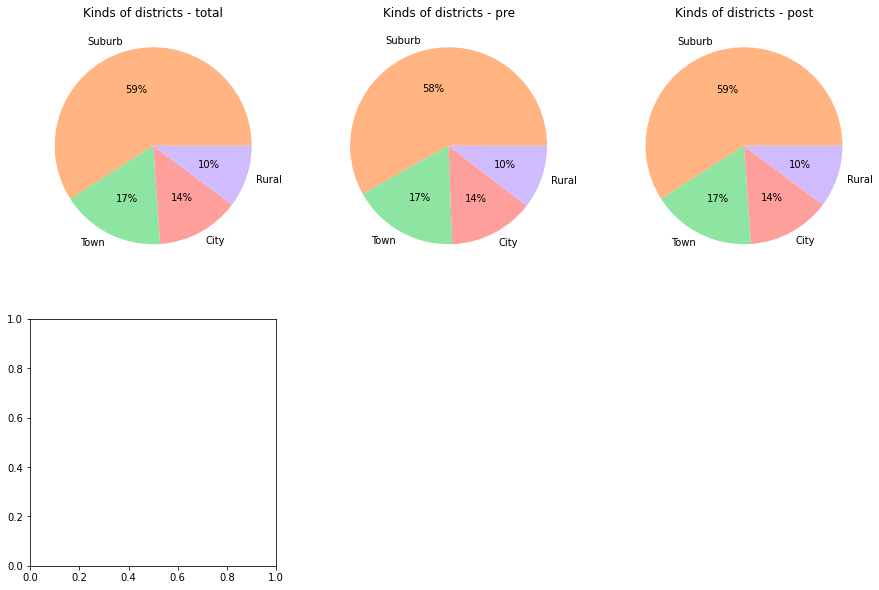

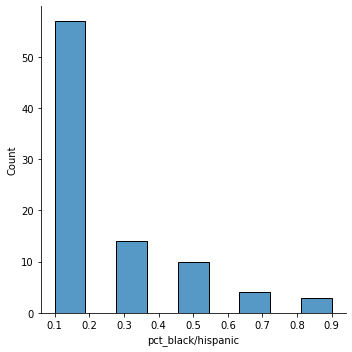

In [70]:
# District types
labels = list(merged_data['locale'].unique())
# Only after finishing this I realized that I could've just used the districts table but it was a good exercise... 😅
district_types = merged_data.groupby(by=['district_id', 'locale'], as_index=False).count()['locale'].value_counts()

district_types_pre = merged_data_pre_covid.groupby(by=['district_id', 'locale'], as_index=False).count()['locale'].value_counts()
district_types_post = merged_data_post_covid.groupby(by=['district_id', 'locale'], as_index=False).count()['locale'].value_counts()

pre_mean = merged_data_pre_covid.groupby(by=['district_id'], as_index=False).mean()['pct_black/hispanic']
post_mean = merged_data_post_covid.groupby(by=['district_id'], as_index=False).mean()['pct_black/hispanic']


# engagement_by_district = merged_data.groupby(['district_id', 'pct_black/hispanic']).agg({'engagement_index': 'mean'}).reset_index()
# print(engagement_by_district.head())

# race
# engagement_by_race = merged_data.groupby(['district', 'pct_black/hispanic']).agg({'': ''})

# social background


plt.figure(figsize=(15, 10))
plt.subplot(2,3,1)

colors = sns.color_palette('pastel')[1:5]
plt.pie(district_types, labels=labels, colors=colors, autopct='%.0f%%')
plt.title('Kinds of districts - total')

plt.subplot(2,3,2)

plt.pie(district_types_pre, labels=labels, colors=colors, autopct='%.0f%%')
plt.title('Kinds of districts - pre')

plt.subplot(2,3,3)

plt.pie(district_types_post, labels=labels, colors=colors, autopct='%.0f%%')
plt.title('Kinds of districts - post')

# plt.subplot(2,3,4)
# sns.displot(pre_mean)

plt.subplot(2,3,4)
sns.displot(post_mean)

# plt.subplot(2,3,6)
# sns.lineplot(data=engagement_by_district, y="pct_black/hispanic")

plt.show()

Analysis of the graph above:
- The distribution of districts (almost) does not change from before to after the pandemic

# Product Usage EDA

In [31]:
pivoted_engagement = pd.pivot_table(merged_data, values='engagement_index', 
    index=["time"],
    columns=['Product Name'], aggfunc=np.sum)
pivoted_engagement.to_csv(data_dir / "product_pivoted_engagement_data.csv")

In [32]:
pivoted_engagement = pd.read_csv(data_dir / "product_pivoted_engagement_data.csv", index_col="time")
sorted_columns = pivoted_engagement.sum().sort_values(ascending=False).index
pivoted_engagement = pivoted_engagement[sorted_columns[:20]]

In [33]:
for i in range(4):
    kernel_size = 5
    df = pivoted_engagement
    for colname in df.columns:
        df["tmp"] = 0
        col_vals = pivoted_engagement[colname].values
        running_mean = np.convolve(col_vals, np.ones(kernel_size)/kernel_size, mode="same")
        df[colname] = running_mean
        df.drop("tmp", axis=1, inplace=True)

<AxesSubplot:xlabel='time'>

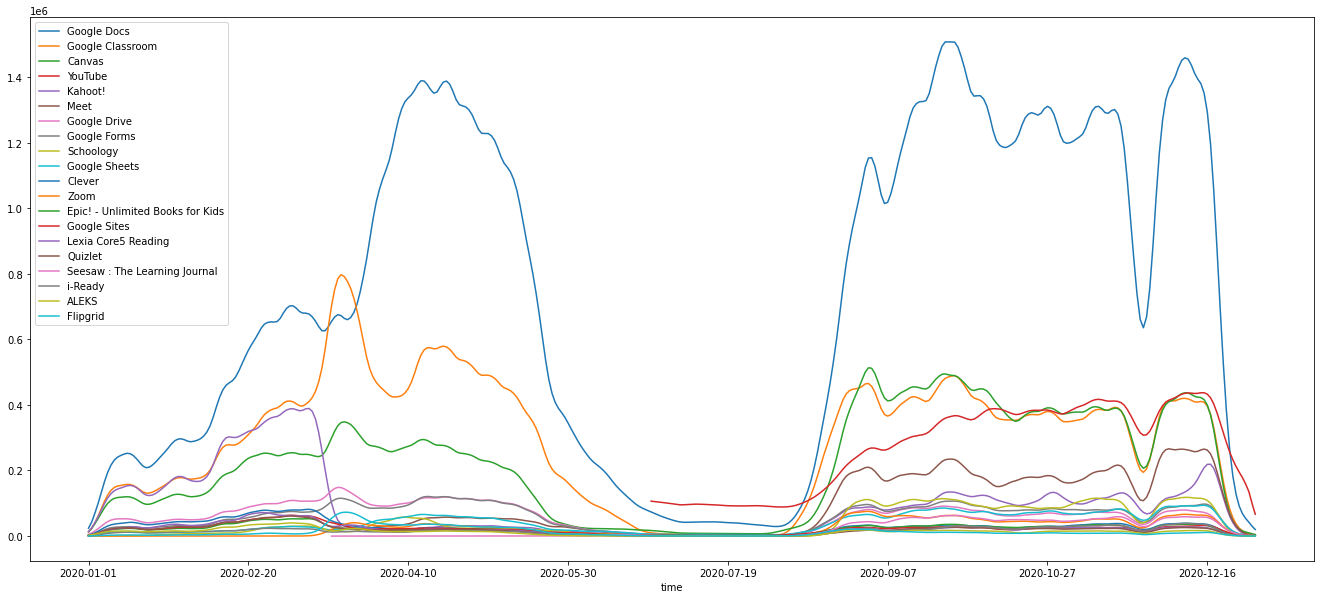

In [36]:
pivoted_engagement.plot(figsize=(23, 10))

The graph above:
- Here, the engagement for the top-10 products can be seen, aggregated over all states and districts to a single number of engagement for each day for each product.
- x-axis = time
- y-axis = engagement-index

Analysis of the graph above:

- Again, shortly after the declaration of covid 19 to be a pandemic, some product's usage increases sharply (google docs, zoom, Epic!) while others drop (Lexia Core5 Reading)
- During summer vacation time, purely school related products usage goes pretty much to 0, while tools that are not only realted to school usage (youtube, google docs) remains a bit above that